## Dependencies 

In [2]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

  Using cached tensorflow-2.4.1-cp36-cp36m-win_amd64.whl (370.7 MB)
  Using cached matplotlib-3.3.4-cp36-cp36m-win_amd64.whl (8.5 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached tensorboard-2.6.0-py3-none-any.whl (5.6 MB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached wrapt-1.12.1-cp36-cp36m-win_amd64.whl
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached Mar

In [3]:
import tensorflow as tf
import numpy as np 
from matplotlib import pyplot as plt
import cv2

In [5]:
interpreter = tf.lite.Interpreter(model_path='lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()

###### The Model input 192x192x3 input and output [1, 1, 17, 3]

In [24]:
# Video Feed
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    #Reshaping the image 
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img,axis=0),192,192)
    input_image = tf.cast(img, dtype=tf.float32)
    
    ## Setting up Input Output
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Prediction
    interpreter.set_tensor(input_details[0]['index'],np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    
    ## Rendering 
    draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
    draw_keypoints(frame, keypoints_with_scores, 0.4)
    #print(keypoints_with_scores)
    cv2.imshow('Feed',frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

###### Just to Know
- np.expand_dims push the image array into a array

In [8]:
frame.shape

(480, 640, 3)

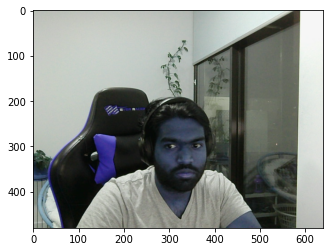

In [10]:
plt.imshow(frame)

## Drawing Keypoints
We multiply the keypoints from prediction with the image size to get the relative position of the anchor
np.squeeze - get a flat array for deeper array

In [16]:
def draw_keypoints(frame, keypoints, confidence):
    y,x,channel = frame.shape
    shaped = np.squeeze(np.multiply(keypoints,[y,x,1]))
    
    for relative_keypoint in shaped:
        ky, kx, kp_confidence = relative_keypoint
        if kp_confidence > confidence:
            cv2.circle(frame, (int(kx), int(ky)),5, (0,255,0),-1)

### Draw Edges

In [19]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [22]:
def draw_connections(frame,keypoints,edges,confidence_threshold):
    y,x,channel = frame.shape
    shaped = np.squeeze(np.multiply(keypoints,[y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if(c1 > confidence_threshold) & (c2 > confidence_threshold):
            cv2.line(frame,(int(x1), int(y1)),(int(x2),int(y2)),(255,0,0),3)